Loaded 80380 documents for analysis.


Token indices sequence length is longer than the specified maximum sequence length for this model (764 > 512). Running this sequence through the model will result in indexing errors


Loaded google/muril-base-cased tokenizer.

--- Document Token Length Statistics (MuRIL) ---
Minimum length: 6
Maximum length: 12447
Average length: 248.36

Percentiles (What percentage of documents fit inside this length):
50th Percentile (Median): 150
75th Percentile: 256
90th Percentile: 759
95th Percentile: 769


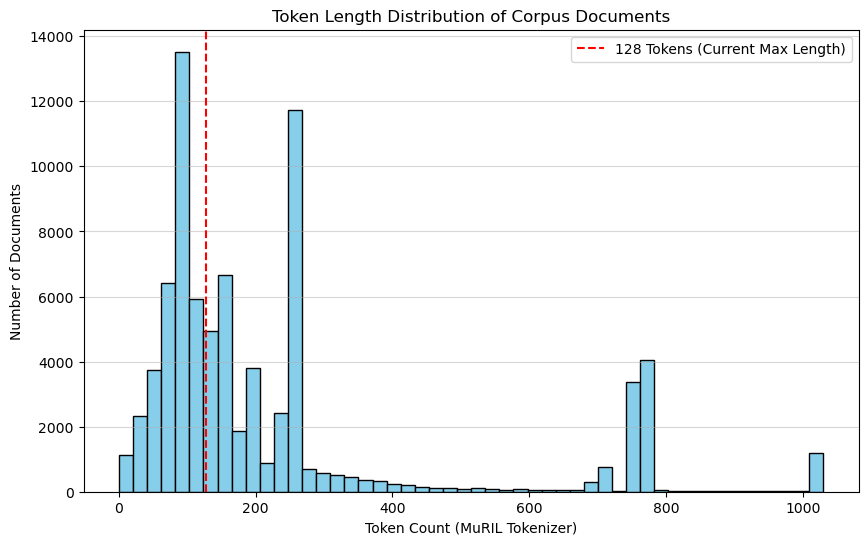

In [ ]:
import pandas as pd
from transformers import AutoTokenizer
import numpy as np
import matplotlib.pyplot as plt
import os

# --- Configuration ---
MODEL_NAME = "google/muril-base-cased"
CORPUS_PATH = 'data/corpus_trec.csv' # Path to your 80k corpus file

def analyze_token_lengths(corpus_path: str):
    # --- 1. Load Data and Tokenizer ---
    if not os.path.exists(corpus_path):
        print(f"Error: Corpus file not found at {corpus_path}")
        return

    corpus_df = pd.read_csv(corpus_path)
    # We only care about the 'text' column
    corpus_texts = corpus_df['text'].dropna().astype(str).tolist()
    
    print(f"Loaded {len(corpus_texts)} documents for analysis.")
    
    # Load the MuRIL tokenizer
    # The 'fast' version is much quicker for batch processing
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    print(f"Loaded {MODEL_NAME} tokenizer.")

    # --- 2. Calculate Token Length for Each Document ---
    
    # We use a simple list comprehension to apply the tokenizer to all texts
    # The length of the 'input_ids' list is the token count, including [CLS] and [SEP]
    token_lengths = [
        len(tokenizer.encode(text, add_special_tokens=True))
        for text in corpus_texts
    ]

    # --- 3. Compute Key Statistics ---
    token_lengths_np = np.array(token_lengths)
    
    # Calculate the crucial percentiles
    p_50 = np.percentile(token_lengths_np, 50)
    p_75 = np.percentile(token_lengths_np, 75)
    p_90 = np.percentile(token_lengths_np, 90)
    p_95 = np.percentile(token_lengths_np, 95)
    
    # --- 4. Print Results (The Decision Makers) ---
    
    print("\n--- Document Token Length Statistics (MuRIL) ---")
    print(f"Minimum length: {token_lengths_np.min()}")
    print(f"Maximum length: {token_lengths_np.max()}")
    print(f"Average length: {token_lengths_np.mean():.2f}")
    
    print("\nPercentiles (What percentage of documents fit inside this length):")
    print(f"50th Percentile (Median): {int(p_50)}")
    print(f"75th Percentile: {int(p_75)}")
    print(f"90th Percentile: {int(p_90)}")
    print(f"95th Percentile: {int(p_95)}")
    
    # --- 5. Optional: Plot Histogram (Visual Confirmation) ---
    plt.figure(figsize=(10, 6))
    # We only plot up to the 99th percentile for a clear view, ignoring massive outliers
    plt.hist(token_lengths_np, bins=50, range=(0, np.percentile(token_lengths_np, 99)), color='skyblue', edgecolor='black')
    
    # Draw a line at the typical 128-token setting
    plt.axvline(x=128, color='red', linestyle='--', label='128 Tokens (Current Max Length)')
    
    plt.title('Token Length Distribution of Corpus Documents')
    plt.xlabel('Token Count (MuRIL Tokenizer)')
    plt.ylabel('Number of Documents')
    plt.legend()
    plt.grid(axis='y', alpha=0.5)
    plt.show()

if __name__ == '__main__':
    analyze_token_lengths(CORPUS_PATH)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import json
import os

def load_data(file_path):
    """Loads CSV data."""
    print(f"Loading data from {file_path}...")
    return pd.read_csv(file_path)

def setup_and_split_data():
    # --- 1. Load Data ---
    corpus_df = load_data('corpus_trec.csv')
    queries_df = load_data('queries.csv')
    gt_df = load_data('ground_truth.csv') # QueryID, relevant_docs

    # --- 2. Create Lookup Tables (Mapping DocID to Text) ---
    doc_id_to_text = dict(zip(corpus_df['DocID'], corpus_df['text']))
    
    # Merge relevance data: QueryID, Query, relevant_docs (DocID)
    relevance_data = pd.merge(queries_df, gt_df, on='QueryID')

    # --- 3. Split Query IDs ---
    all_qids = relevance_data['QueryID'].unique()
    train_qids, test_qids = train_test_split(
        all_qids, test_size=0.5, random_state=42
    )

    # Filter relevance data into train and test sets
    train_relevance = relevance_data[relevance_data['QueryID'].isin(train_qids)]
    test_relevance = relevance_data[relevance_data['QueryID'].isin(test_qids)]

    # --- 4. Save Train/Test Metadata ---
    if not os.path.exists('data_output'):
        os.makedirs('data_output')
        
    train_relevance.to_csv('data_output/train_relevance.csv', index=False)
    test_relevance.to_csv('data_output/test_relevance.csv', index=False)
    corpus_df.to_csv('data_output/corpus_data.csv', index=False)
    
    # Save the DocID to Text map as a JSON file for quick lookups
    with open('data_output/docid_to_text.json', 'w', encoding='utf-8') as f:
        json.dump(doc_id_to_text, f, ensure_ascii=False)

    print("\nData Setup Complete.")
    print(f"Training Queries: {len(train_relevance)} | Test Queries: {len(test_relevance)}")

if __name__ == '__main__':
    setup_and_split_data()

Loading data from data/corpus_trec.csv...
Loading data from data/queries.csv...
Loading data from data/groundtruth.csv...

Data Setup Complete.
Training Queries: 500 | Test Queries: 500


In [ ]:
import pandas as pd
import re
import json
import numpy as np
from rank_bm25 import BM25Okapi
from typing import List

_DEVANAGARI_PATTERN = re.compile(r'[\u0900-\u0963\u0966-\u097F]+')

with open("data/stopwords.txt", "r", encoding="utf-8") as f:
    _STOPWORDS = set(line.strip() for line in f)


def simple_tokenizer(text):
    # extract words but ignore । and ॥
    words = _DEVANAGARI_PATTERN.findall(text)
    return [word for word in words if word not in _STOPWORDS]

def bm25_mine_negatives(train_relevance_path: str, corpus_path: str, top_k: int = 100):
    # --- 1. Load Data ---
    train_relevance = pd.read_csv(train_relevance_path)
    corpus_df = pd.read_csv(corpus_path)
    
    corpus_texts = corpus_df['text'].tolist()
    doc_ids = corpus_df['DocID'].tolist()
    doc_id_to_index = {doc_id: i for i, doc_id in enumerate(doc_ids)}
    
    # --- 2. BM25 Indexing ---
    tokenized_corpus = [simple_tokenizer(doc) for doc in corpus_texts]
    bm25 = BM25Okapi(tokenized_corpus)
    print(f"BM25 index built for {len(corpus_texts)} documents.")
    
    # --- 3. Mining Hard Negatives ---
    triplets = []
    
    for _, row in train_relevance.iterrows():
        query = row['Query']
        gt_doc_id = row['relevant_docs'] # The one known positive (GT-P)
        
        tokenized_query = simple_tokenizer(query)
        doc_scores = bm25.get_scores(tokenized_query)
        ranked_indices = np.argsort(doc_scores)[::-1]
        
        # 4. Find the Hard Negative (HN)
        positive_index = doc_id_to_index.get(gt_doc_id)
        
        # Iterate through the top-K BM25 results
        for idx in ranked_indices:
            current_doc_id = doc_ids[idx]
            
            # Condition 1: Must be high-ranking (Hard)
            # Condition 2: Must NOT be the known positive document (Negative)
            if idx != positive_index and np.where(ranked_indices == idx)[0][0] < top_k:
                # We use the first valid hard negative found (e.g., rank 2 or 3, if not GT-P)
                hn_doc_id = current_doc_id
                
                triplets.append({
                    "query_id": row['QueryID'],
                    "query": query,
                    "positive_id": gt_doc_id,
                    "negative_id": hn_doc_id,
                    "positive_text": corpus_df.loc[corpus_df['DocID'] == gt_doc_id, 'text'].iloc[0],
                    "negative_text": corpus_df.loc[corpus_df['DocID'] == hn_doc_id, 'text'].iloc[0]
                })
                break # Move to the next query once one hard negative is selected

    # --- 5. Save Triplets ---
    triplets_df = pd.DataFrame(triplets)
    triplets_df.to_csv('data_output/initial_train_triplets.csv', index=False)
    print(f"\nInitial {len(triplets)} train triplets saved.")

if __name__ == '__main__':
    bm25_mine_negatives('data_output/train_relevance.csv', 'data_output/corpus_data.csv')

BM25 index built for 80380 documents.

Initial 500 train triplets saved.


In [ ]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel, Trainer, TrainingArguments
from datasets import Dataset
import pandas as pd
from typing import Dict, Any
from dataclasses import dataclass

# Define the MuRIL model name and sequence length
MODEL_NAME = "google/muril-base-cased"
MAX_LENGTH = 512

@dataclass
class TripleCollator:
    tokenizer: AutoTokenizer
    
    def __call__(self, features):
        return {
            'query': {
                'input_ids': torch.stack([torch.tensor(f['query_input_ids']) for f in features]),
                'attention_mask': torch.stack([torch.tensor(f['query_attention_mask']) for f in features])
            },
            'positive': {
                'input_ids': torch.stack([torch.tensor(f['positive_input_ids']) for f in features]),
                'attention_mask': torch.stack([torch.tensor(f['positive_attention_mask']) for f in features])
            },
            'negative': {
                'input_ids': torch.stack([torch.tensor(f['negative_input_ids']) for f in features]),
                'attention_mask': torch.stack([torch.tensor(f['negative_attention_mask']) for f in features])
            }
        }

# --- Custom Trainer for Contrastive Loss (InfoNCE/In-Batch Negatives) ---
class BiEncoderTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        # inputs contains tokenized query, positive, and negative texts

        # 1. Forward Pass to get [CLS] embeddings
        q_out = model(**inputs['query'])
        p_out = model(**inputs['positive'])
        n_out = model(**inputs['negative'])
        
        # CLS token embeddings are at index 0
        q_emb = q_out.last_hidden_state[:, 0, :]
        p_emb = p_out.last_hidden_state[:, 0, :]
        n_emb = n_out.last_hidden_state[:, 0, :]

        # 2. Combine positives and negatives for In-Batch Contrastive Loss
        # The positive document is the first item (batch_size, D)
        # All other documents (positives and negatives) are candidates (2*batch_size, D)
        doc_embs = torch.cat([p_emb, n_emb], dim=0) # Concatenate P and N embeddings

        # 3. Calculate Similarity (Dot Product)
        # Scores shape: (batch_size, 2 * batch_size)
        # scores[i, j] is similarity between query i and document j
        scores = torch.matmul(q_emb, doc_embs.transpose(0, 1))

        # 4. Target Labels
        # For the first half of the scores matrix (dot product of Q_i and P_i), the target is 0.
        # This means the P_i document is the correct match for Q_i.
        target = torch.arange(q_emb.size(0), device=q_emb.device)
        
        # 5. Calculate Loss (Cross-Entropy on similarities)
        # This is equivalent to InfoNCE Loss
        loss = F.cross_entropy(scores, target)

        return (loss, None) if return_outputs else loss

def train_muril_biencoder(triplets_path: str):
    # --- 1. Load Data and Tokenizer ---
    df = pd.read_csv(triplets_path)
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    
    # Use the same model for both query and document encoding (Bi-Encoder)
    model = AutoModel.from_pretrained(MODEL_NAME)

    # --- 2. Prepare Dataset ---
    raw_dataset = Dataset.from_pandas(df)

    def tokenize_function(examples: Dict[str, Any]):
        query_enc = tokenizer(examples['query'], max_length=MAX_LENGTH, truncation=True, padding='max_length')
        positive_enc = tokenizer(examples['positive_text'], max_length=MAX_LENGTH, truncation=True, padding='max_length')
        negative_enc = tokenizer(examples['negative_text'], max_length=MAX_LENGTH, truncation=True, padding='max_length')
        
        return {
            'query_input_ids': query_enc['input_ids'],
            'query_attention_mask': query_enc['attention_mask'],
            'positive_input_ids': positive_enc['input_ids'],
            'positive_attention_mask': positive_enc['attention_mask'],
            'negative_input_ids': negative_enc['input_ids'],
            'negative_attention_mask': negative_enc['attention_mask']
        }

    tokenized_dataset = raw_dataset.map(tokenize_function, batched=True, remove_columns=df.columns.tolist())
    
    # --- 3. Training Arguments ---
    training_args = TrainingArguments(
        output_dir="./muril_dr_checkpoints",
        num_train_epochs=3, # Typically 3-5 epochs for DR
        per_device_train_batch_size=8, # Adjust based on your GPU memory
        learning_rate=2e-5,
        warmup_steps=100,
        weight_decay=0.01,
        logging_dir='./logs',
        save_total_limit=1,
        fp16=torch.cuda.is_available(), # Use mixed precision if GPU is available
    )

    # --- 4. Initialize and Train ---
    trainer = BiEncoderTrainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset,
        data_collator=TripleCollator(tokenizer)
    )

    print("Starting MuRIL fine-tuning...")
    trainer.train()
    
    # --- 5. Save Final Model ---
    final_model_path = "./final_muril_encoder"
    trainer.save_model(final_model_path)
    tokenizer.save_pretrained(final_model_path)
    print(f"\nFinal MuRIL encoder saved to {final_model_path}")

if __name__ == '__main__':
    # You must run the BM25 mining script first to generate this file
    train_muril_biencoder('data_output/initial_train_triplets.csv')

In [15]:
%pip install transformers[torch]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.
